#Academic Text Summarization

The purpous of this project is to train an LLM model on a custom dataset of academic articles in order to create their summarization in the form of abstract paragraph. The summarization of the articles will be done using a pretrain LLM called BART, its biderectional architecture makes it a suitable choice for summarization task.

The dataset had been gathered from NCBI - National Center of Biotechnology Information. Farther details of dataset gather are in adjacent notebook under same github repository.

Before the summarization itself, belowe presented several text preprocessing and embedding techniques.

This jupyther notebook had been created in google colab env.

In [2]:
from google.colab import drive
mount = '/content/drive'
drive.mount(mount)

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/Colab Notebooks/NLP/PMC_Centralized_data"

#Statistical information

Before any NLP related tasks, first lets get some insight of the corpus.

In [5]:
import os
import glob

def analyze_folder_statistics(folder_path):
    """ Analyze text files in the specified folder to gather statistics about word counts. """
    file_paths = glob.glob(os.path.join(folder_path, "*.txt"))  # Collect all text files
    num_files = len(file_paths)

    if num_files == 0:
        return "No text files found in the specified folder."

    word_counts = []

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            content = file.read()
            word_count = len(content.split())  # Simple split by whitespace to count words
            word_counts.append(word_count)

    max_words = max(word_counts)
    min_words = min(word_counts)
    average_words = sum(word_counts) / num_files

    return {
        "total_files": num_files,
        "max_words": max_words,
        "min_words": min_words,
        "average_words": average_words
    }

stats = analyze_folder_statistics(data_path)
print(stats)

{'total_files': 87, 'max_words': 7485, 'min_words': 814, 'average_words': 2538.1954022988507}


This method will read the article from disc, and more importantly, separete it to abstract paragraph - which later be used as label, and body which is the text itself - later be used as data.

In [6]:
def read_article_sections(file_path):
    """ Read a specified article file and extract its abstract and body text. """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables to capture abstract and body
    abstract_text = []
    body_text = []
    current_section = None

    # Identify sections by their starting markers
    for line in lines:
        clean_line = line.strip()
        if clean_line.startswith("Abstract:"):
            current_section = 'abstract'
            # Remove the "Abstract:" part and start appending text
            abstract_text.append(clean_line[9:])  # Assumes "Abstract: " is 9 characters long including the space
        elif clean_line.startswith("Body:"):
            current_section = 'body'
            # Remove the "Body:" part and start appending text
            body_text.append(clean_line[5:])  # Assumes "Body: " is 5 characters long including the space
        elif current_section == 'abstract' and clean_line and len(clean_line) > 0:
            abstract_text.append(clean_line)
        elif current_section == 'body' and clean_line and len(clean_line) > 0:
            body_text.append(clean_line)

    # Join lines to form cohesive sections
    abstract = "\n".join(abstract_text)
    abstract = abstract.replace("\n", " ")
    abstract = abstract.encode('utf-8', errors='ignore').decode('utf-8')
    body = "\n".join(body_text)
    body = body.replace("\n", " ")
    body = body.encode('utf-8', errors='ignore').decode('utf-8')

    #print("Abstract:\n", abstract)
    #print("\nBody Text:\n", body)
    return abstract, body

file_path = "/content/drive/MyDrive/Colab Notebooks/NLP/PMC_Centralized_data/A Comprehensive Assessment of Soft-tissue Sagging .txt"
abstract, body = read_article_sections(file_path)
print(abstract)
print(body)

 Overdevelopment of zygomatic bones often results in protrusion and flaring of the midfacial region. This makes the face appear squarer than the more favorable oval shape. Therefore, zygoma reduction surgery has become a commonly performed procedure in patients seeking to obtain an ideal facial shape. Facial soft-tissue ptosis is one of the main complications of zygoma reduction surgery. Previously, the evaluation of cheek soft-tissue ptosis was subjectively based on patients and surgeons. Our study aimed to provide an objective evaluation of soft-tissue sagging in the cheek region after zygoma reduction surgery using artificial intelligence (AI). We used AI to evaluate cheek sagging in a series of patients who underwent zygoma reduction surgery. We used four methods: tracking facial landmarks, detecting changes in the cheek curvature, and examining changes in the nasolabial fold and marionette lines. Then, the obtained numerical results were assessed for statistically significant diff

# Tokennization, Lemmatization, Stopwords remove

Basic text preprocessing techniques, made for prepearing the text data for farther manipulations.

Tokennization separate the text to individual tokens, typicly word size (or less).

Lemmatization - converts a word to its dictionary form, which helps reduce noice and varaity in the data.

Stopwords remove - delete all unnecesary additions to text which do not contribute information such as: a, an, the, etc.

In [7]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [8]:
import re

def process_text(text):
    # Process the text with the SpaCy pipeline
    doc = nlp(text)

    # Generate a list of tokens after lemmatization and stopword removal
    # Additional filters for non-alphanumeric characters or specific patterns
    tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop
        and not token.is_punct
        and token.is_alpha  # Ensures the token is fully alphabetic
        and not re.search(r'[\x00-\x1f\x7f-\x9f]', token.text)  # Regex to exclude control characters
    ]

    return tokens

In [9]:
processed_documents = {}

for file in os.listdir(data_path):
    if file.endswith(".txt"):
        file_path = os.path.join(data_path, file)
        abstract, body = read_article_sections(file_path)

        # Process text sections
        processed_abstract = process_text(abstract)
        processed_body = process_text(body)

        # Store or print results
        processed_documents[file] = {
            'processed_abstract': processed_abstract,
            'processed_body': processed_body
        }

# Example to print processed results
for filename, content in processed_documents.items():
    print(f'Filename: {filename}')
    print('Processed Abstract:', content['processed_abstract'])
    print('Processed Body:', content['processed_body'])

    print('-' * 80)



Filename: Simultaneous Utilization of Mood Disorder Question.txt
Processed Abstract: ['bipolar', 'depressive', 'disorder', 'distinct', 'disorder', 'clearly', 'different', 'clinical', 'course', 'distinguish', 'present', 'clinical', 'challenge', 'study', 'investigate', 'utility', 'self', 'report', 'questionnaire', 'mood', 'disorder', 'questionnaire', 'mdq', 'bipolar', 'spectrum', 'diagnostic', 'scale', 'bsds', 'machine', 'learning', 'base', 'multivariate', 'analysis', 'classify', 'patient', 'bipolar', 'depressive', 'disorder', 'total', 'patient', 'bipolar', 'disorder', 'depressive', 'disorder', 'include', 'study', 'participant', 'complete', 'mdq', 'bsds', 'questionnaire', 'machine', 'learn', 'classifier', 'include', 'support', 'vector', 'machine', 'svm', 'linear', 'discriminant', 'analysis', 'lda', 'exploit', 'multivariate', 'analysis', 'classification', 'performance', 'assess', 'cross', 'validation', 'mdq', 'bsds', 'demonstrate', 'significant', 'difference', 'item', 'total', 'score', 'g

Most of the models require the text to be presented as a single string, hence after the pipeline above, i shall connect the text for farther processing.

In [10]:
centralCorpus = []
for filename, content in processed_documents.items():
    fullText = ' '.join(content['processed_abstract'])
    centralCorpus.append(fullText)
    centralCorpus.append(' '.join(content['processed_body']))

print((centralCorpus[0]))

bipolar depressive disorder distinct disorder clearly different clinical course distinguish present clinical challenge study investigate utility self report questionnaire mood disorder questionnaire mdq bipolar spectrum diagnostic scale bsds machine learning base multivariate analysis classify patient bipolar depressive disorder total patient bipolar disorder depressive disorder include study participant complete mdq bsds questionnaire machine learn classifier include support vector machine svm linear discriminant analysis lda exploit multivariate analysis classification performance assess cross validation mdq bsds demonstrate significant difference item total score group machine learning base multivariate analysis include svm achieve excellent discrimination level area roc curve auc value exceed questionnaire individually particular combination mdq bsds improve classification performance yield auc study suggest application machine learning mdq bsds assist distinguish bipolar depressiv

#TF-IDF

Words frequency in corpus. This technique helps determain the most important words in the text corpus.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(centralCorpus)

print("Shape of TF-IDF Matrix:", X.shape)
print("Feature Names:", vectorizer.get_feature_names_out())

# Each row represents a document. Each column a unique word.
# The value is the TF-IDF score
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df = df.max().sort_values(ascending=False).head(20)
df

Shape of TF-IDF Matrix: (174, 9218)
Feature Names: ['aa' 'aap' 'ab' ... 'δscore' 'μl' 'μm']


,0
vf,0.886581
chatgpt,0.853810
promoter,0.796271
ctcf,0.795882
af,0.777023
spike,0.736186
hf,0.701171
gait,0.683454
diffractive,0.681870
threat,0.680759


In [12]:
# Get the scores for each word across all documents
word_scores = np.max(X.toarray(), axis=0)

# Combine scores with words
words_with_scores = list(zip(vectorizer.get_feature_names_out(), word_scores))

# Sort by score
most_significant_words = sorted(words_with_scores, key=lambda x: x[1], reverse=True)

# Display the top N words
print(most_significant_words[:20])

[('vf', 0.8865812063803261), ('chatgpt', 0.8538100915853574), ('promoter', 0.7962705377381301), ('ctcf', 0.7958824809931624), ('af', 0.7770233134788657), ('spike', 0.736186491478514), ('hf', 0.7011708387718123), ('gait', 0.6834537583898861), ('diffractive', 0.6818703964936083), ('threat', 0.6807592261446146), ('unidirectional', 0.6785142161764163), ('grain', 0.6779096330287493), ('infant', 0.6725605433454088), ('erp', 0.66878862965349), ('cardiologist', 0.6625244394085337), ('protein', 0.6616691660599968), ('cpr', 0.6605937159344241), ('ibd', 0.657464490468381), ('stroke', 0.6557795268761882), ('genome', 0.6190706944757024)]


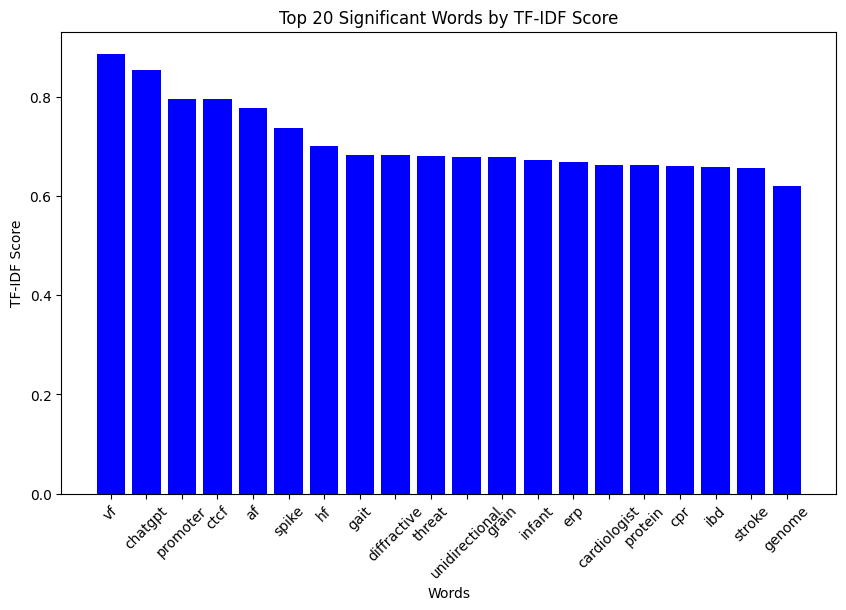

In [13]:
import matplotlib.pyplot as plt

N = 20  # Number of top words to display
top_words = most_significant_words[:N]
words, scores = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(words, scores, color='blue')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title(f'Top {N} Significant Words by TF-IDF Score')
plt.xticks(rotation=45)
plt.show()

Excluding "vf" - ventricular fibrillation, which i dont know exactly what does it mean, for vf being a medical term related to heart fucntion, the most significant word is "chatGPT".

This makes perfect sence considering i've chosen articales dealing with AI, ML, DL, NLP etc. So only from this we can conclude that the sientifical comunity highly relaying on chatGPT for their research. Also we can see words like "prompter" which also goes under same roof of AI.

Now considering that the dataset itself made from medical articles, we can see words like "protein", "stroke", and "cardiologist" which aline with the medical thematic of the dataset.

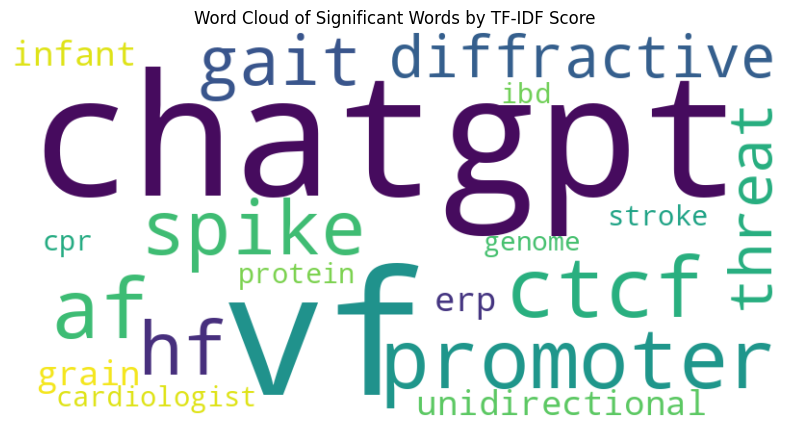

In [14]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(df)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Word Cloud of Significant Words by TF-IDF Score')
plt.show()

# Word2Vec embedding

by utilizing a pretrained model on pretty much all the words out there, the model can take in account the words from the corpus and generate an numerical representation for each one. This numerical vector, can later be used for other neural network model such as autoencoders, or even summarization models themself.

In [15]:
len(centralCorpus)

174

In [16]:
import nltk
from nltk.tokenize import word_tokenize
# Download the nltk data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# To save excecution time ill use nltk and not spacy
tokenized_text =  [word_tokenize(document.lower()) for document in centralCorpus]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
print((tokenized_text[0]))

['bipolar', 'depressive', 'disorder', 'distinct', 'disorder', 'clearly', 'different', 'clinical', 'course', 'distinguish', 'present', 'clinical', 'challenge', 'study', 'investigate', 'utility', 'self', 'report', 'questionnaire', 'mood', 'disorder', 'questionnaire', 'mdq', 'bipolar', 'spectrum', 'diagnostic', 'scale', 'bsds', 'machine', 'learning', 'base', 'multivariate', 'analysis', 'classify', 'patient', 'bipolar', 'depressive', 'disorder', 'total', 'patient', 'bipolar', 'disorder', 'depressive', 'disorder', 'include', 'study', 'participant', 'complete', 'mdq', 'bsds', 'questionnaire', 'machine', 'learn', 'classifier', 'include', 'support', 'vector', 'machine', 'svm', 'linear', 'discriminant', 'analysis', 'lda', 'exploit', 'multivariate', 'analysis', 'classification', 'performance', 'assess', 'cross', 'validation', 'mdq', 'bsds', 'demonstrate', 'significant', 'difference', 'item', 'total', 'score', 'group', 'machine', 'learning', 'base', 'multivariate', 'analysis', 'include', 'svm', '

In [18]:
from gensim.models import Word2Vec

# Train the Word2Vec model
word2vec_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, workers=3, sg=0)

# Save the model
word2vec_model.save("word2vec.model")

print('Embedding of the word: DNA')
print(word2vec_model.wv['dna'])

# Find most similar words
print('\nSimilar words to DNA')
print(word2vec_model.wv.most_similar('dna'))

Embedding of the word: DNA
[ 0.0681542   0.3964639   0.22329754 -0.18373683 -0.14119846 -0.39130804
  0.17515728  0.7763598  -0.10351183 -0.05297873  0.01630003 -0.3144039
 -0.05514345 -0.09161734  0.04805544 -0.16554219  0.3239445  -0.34173304
  0.10828014 -0.5085872   0.16670607  0.20811239 -0.03804849 -0.12258495
  0.09422771 -0.0526957  -0.35226265 -0.12588198 -0.17367464 -0.38318697
  0.03444301  0.19307026 -0.23447299 -0.03875333  0.20973751  0.46280384
  0.25616407 -0.3170071  -0.23064359 -0.32364905  0.07460415 -0.12484785
 -0.15592548 -0.11187587  0.13579859 -0.35751945 -0.16303837  0.12351513
  0.05183333  0.09366697  0.3728464  -0.292791   -0.12487432 -0.07654119
 -0.30121484  0.0294723   0.27714685 -0.0665239  -0.16956334  0.1864816
  0.25657335  0.07985318  0.11557592  0.27166292 -0.1340117   0.23545755
  0.15161881  0.13488425 -0.38768423  0.22830273 -0.2068533   0.10404876
  0.2541269  -0.10630198 -0.00647799  0.137126   -0.02243956 -0.24968432
 -0.04980412  0.1262178  -

In previous work, i've visualized the simillarity between diffrent words using PCA technique for dimentiality reduction. This time, considering the side of corpus and embedding vector, using similar technique may result in huge lost of data and accuracy of representation, hence ill demonstrate it differently:

The code below finds the 10 most simillar words to everyother word in the corpus. In other words, the semantic meaning of the words below shows the general, or the avarage idea of the corpus in a way. differently stated, the articles in the data set mainly dealing with "visual" and its similarities, "scan" and its semantic similarities etc.

In [19]:
def average_similarity(word, model):
    similar_words = model.wv.most_similar(word, topn=len(model.wv))
    return sum([sim for _, sim in similar_words]) / len(similar_words)

word_similarity = {word: average_similarity(word, word2vec_model) for word in word2vec_model.wv.index_to_key}
sorted_by_similarity = sorted(word_similarity.items(), key=lambda x: x[1], reverse=True)

# Top meaningful words based on their centrality
most_central_words = sorted_by_similarity[:10]

In [20]:
most_central_words

[('addition', 0.9111908723690407),
 ('visual', 0.9111790739918452),
 ('m', 0.9111750027061504),
 ('short', 0.9111732240024673),
 ('affect', 0.9111596883003217),
 ('project', 0.9111555351126),
 ('device', 0.9111325384275737),
 ('limit', 0.9111312283029815),
 ('find', 0.9111207625080362),
 ('scan', 0.911117216910537)]

# AutoEncodding
generates and encoded vertion of the words in corpus. By combining it along with word2vec embedding the result can be a compressed representation of the text, which holds to semantic and contextual properties of the text.

In [21]:
def document_vector(doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv]
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model.wv[doc], axis=0)

# Apply this function to each document in your corpus
doc_vectors = np.array([document_vector(doc) for doc in tokenized_text])
doc_vectors.shape

(174, 100)

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_dim = word2vec_model.vector_size  # Word2Vec vector size

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  # mse might be more appropriate here

autoencoder.summary()

# Training
autoencoder.fit(doc_vectors, doc_vectors,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │           6,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,156 (67.02 KB)

 Trainable params: 17,156 (67.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3412 - val_loss: 0.3427
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3383 - val_loss: 0.3397
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.3355 - val_loss: 0.3370
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.3328 - val_loss: 0.3340
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.3299 - val_loss: 0.3306
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.3266 - val_loss: 0.3270
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3230 - val_loss: 0.3231
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3192 - val_loss: 0.3188
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.3150 - val_loss: 0.3141
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.3104 - val_loss: 0.3089
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3053 - val_loss: 0.3034
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2999 - val

# Word clusters with Autoencoder embedding

A demonstration for use of the autoencoding is words cluster. the numerical vector value space, which represent each word, may be seperated to several different clusters, which devides the words of corpus to diffrent categories by their semantic and contextual properties.

In [23]:
encoder = Model(input_layer, encoded)
encoded_docs = encoder.predict(doc_vectors)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [24]:
from sklearn.cluster import KMeans

# Choose the number of clusters
n_clusters = 5  # Adjust this based on your specific needs or domain knowledge

# Initialize and fit K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(encoded_docs)

# Now 'clusters' contains the cluster indices assigned to each document

for i in range(n_clusters):
    print(f"\nCluster {i+1}")
    cluster_docs = [tokenized_text[idx] for idx, label in enumerate(clusters) if label == i]
    # Optionally print out the documents or analyze their content
    # For example, you can print summaries or key excerpts
    print(cluster_docs[:5])  # Print first 5 documents in the cluster as examples


Cluster 1
[['overdevelopment', 'zygomatic', 'bone', 'result', 'protrusion', 'flaring', 'midfacial', 'region', 'make', 'face', 'appear', 'squarer', 'favorable', 'oval', 'shape', 'zygoma', 'reduction', 'surgery', 'commonly', 'perform', 'procedure', 'patient', 'seek', 'obtain', 'ideal', 'facial', 'shape', 'facial', 'soft', 'tissue', 'ptosis', 'main', 'complication', 'zygoma', 'reduction', 'surgery', 'previously', 'evaluation', 'cheek', 'soft', 'tissue', 'ptosis', 'subjectively', 'base', 'patient', 'surgeon', 'study', 'aim', 'provide', 'objective', 'evaluation', 'soft', 'tissue', 'sagging', 'cheek', 'region', 'zygoma', 'reduction', 'surgery', 'artificial', 'intelligence', 'ai', 'ai', 'evaluate', 'cheek', 'sag', 'series', 'patient', 'undergo', 'zygoma', 'reduction', 'surgery', 'method', 'track', 'facial', 'landmark', 'detect', 'change', 'cheek', 'curvature', 'examine', 'change', 'nasolabial', 'fold', 'marionette', 'line', 'obtain', 'numerical', 'result', 'assess', 'statistically', 'signifi

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


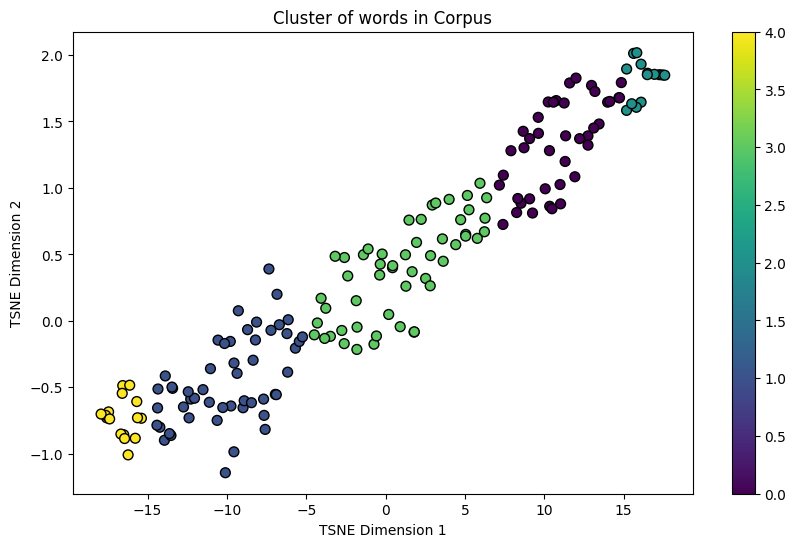

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=0)
reduced_dims = tsne.fit_transform(encoded_docs)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_dims[:, 0], reduced_dims[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.colorbar()
plt.title('Cluster of words in Corpus')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.show()

#NER - Name Entity Recognition

Assigning a tag to each element of a sentence. this helps keep the context of tokenized sentences, and praticulary useful for text-to-text tasks like translation or summarization.

In [26]:
import spacy
nlp = spacy.load('en_core_web_sm')  # Loading the English model
doc = nlp("Apple Inc. announced its earnings on Thursday.")
for ent in doc.ents:
    print(ent.text, ent.label_)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Apple Inc. ORG
Thursday DATE


In [27]:
file_path = "/content/drive/MyDrive/Colab Notebooks/NLP/PMC_Centralized_data/A Comprehensive Assessment of Soft-tissue Sagging .txt"
abstract, body = read_article_sections(file_path)
doc = nlp(abstract)
for ent in doc.ents:
    print(ent.text, ent.label_)

AI ORG
AI ORG
four CARDINAL
AI ORG
four CARDINAL


In [28]:
doc = nlp(body)
for ent in doc.ents:
    print(ent.text, ent.label_)

AI ORG
the World Medical Association Declaration of Helsinki ORG
the Korea National Institute for Bioethics Policy ORG
301 CARDINAL
January 2018 DATE
September 2022 DATE
1-year DATE
at least 1 year DATE
Botox NORP
Table Exclusion Criteria Surgery ORG
cm PERSON
mm PERSON
four CARDINAL
two CARDINAL
two CARDINAL
EOS ORG
17–55 mm QUANTITY
35 mm QUANTITY
45-degree QUANTITY
The CareMind, Inc. ( ORG
Seoul GPE
South Korea GPE
two CARDINAL
Zero CARDINAL
Deep Curve Estimation ORG
Zero CARDINAL
four CARDINAL
Moire PERSON
Thirteen CARDINAL
Hessian NORP
Wilcoxon ORG
Kolmogorov NORP
Smirnov NORP
Shapiro–Wilk PERSON
Kolmogorov NORP
Smirnov NORP
Shapiro–Wilk PERSON
82 CARDINAL
Ten CARDINAL
72 CARDINAL
52 CARDINAL
20 CARDINAL
29.48 CARDINAL
4.88 years DATE
at least 1 year DATE
12–36 CARDINAL
Table Patient Demographics Numerical ORG
13 CARDINAL
Fig PERSON
the AI Assessment Data ORG
Preoperative PERSON
13 CARDINAL
Fig PERSON
Preoperative PERSON
Hessian NORP
0.01 CARDINAL
less than 0.01 CARDINAL
Fig PERSO

#Article Summarization

Now what we came for - article summarization.

First thing to do is to define a dataset class. This allows to define a custom way to access the next element of the data, and apply any transformations or additional processing of the fetch text. Important to mentioned that the dataset class __getitem__ method shall return not only the data itself but the label, or in this case the abstract of the article.

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader

class AcademicArticlesDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.file_paths = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        abstract, body = read_article_sections(file_path)

        sample = {'abstract': abstract, 'body': body}

        if self.transform:
            sample = self.transform(sample)

        return sample

#Train Test spilt

taking small portion of the dataset and hide it away from the training of the model in order to later test the model performances on data that it never saw. A standard approach in ML.

In [30]:
from torch.utils.data import random_split

# Assuming you have instantiated your dataset
dataset = AcademicArticlesDataset(data_path)

# Define the proportions or absolute numbers
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # Now you can create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# BART
For the summarization task itself, i shall use the BART model. The BART (Bidirectional and Auto-Regressive Transformers) model is a transformer-based machine learning model for natural language processing tasks. Developed by Facebook, it combines bidirectional context encoding (like BERT) and auto-regressive decoding (like GPT) into a single framework. It's particularly effective for tasks that involve generating text, like summarization, translation, and text generation.

In [31]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_l

prepearing the data for training

In [33]:
def collate_fn(batch):
    inputs = tokenizer([x['body'] for x in batch], padding=True, truncation=True, max_length=1024, return_tensors="pt")
    labels = tokenizer([x['abstract'] for x in batch], padding=True, truncation=True, max_length=256, return_tensors="pt").input_ids
    labels[labels == tokenizer.pad_token_id] = -100  # To ignore padding in the loss calculation
    return inputs.input_ids, inputs.attention_mask, labels

trainloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)

In [34]:
# prompt: clear cash from device
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Enable more verbose CUDA error reporting
# model.to('cpu')
torch.cuda.empty_cache()
#model.to('cpu')

In [35]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(3):  # Number of epochs
    for input_ids, attention_mask, labels in trainloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"Loss: {loss.item()}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Loss: 2.656952142715454
Loss: 2.5707318782806396
Loss: 2.9672067165374756
Loss: 2.5308046340942383
Loss: 3.177701473236084
Loss: 3.255824327468872
Loss: 2.736750602722168
Loss: 2.4873807430267334
Loss: 2.7367353439331055
Loss: 2.8796589374542236
Loss: 2.5778653621673584
Loss: 3.0843019485473633
Loss: 2.1696553230285645
Loss: 3.1462132930755615
Loss: 2.0825259685516357
Loss: 2.974895715713501
Loss: 3.2549235820770264
Loss: 2.67336106300354
Loss: 3.2324187755584717
Loss: 2.5677378177642822
Loss: 3.109962224960327
Loss: 2.596790075302124
Loss: 2.800262689590454
Loss: 3.184011936187744
Loss: 2.4124650955200195
Loss: 2.524245500564575
Loss: 3.421724557876587
Loss: 2.997205972671509
Loss: 2.9417662620544434
Loss: 3.1815617084503174
Loss: 2.813065528869629
Loss: 3.035982370376587
Loss: 3.3368279933929443
Loss: 2.635286569595337
Loss: 3.5855469703674316
Loss: 3.28908109664917
Loss: 3.084872007369995
Loss: 2.402282238006592
Loss: 2.7426416873931885
Loss: 1.5089292526245117
Loss: 1.5344527959823

In [39]:
model.save_pretrained('saved_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


#BERTScore
is a metric for evaluating text generation quality, such as in machine translation, text summarization, and image captioning. It leverages the embeddings from pre-trained models like BERT to assess the similarity between words in candidate and reference texts. The main advantage of BERTScore is that it evaluates semantic similarity rather than relying solely on lexical matches, which can lead to higher correlation with human judgment.

In [37]:
!pip install bert-score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [40]:
from bert_score import score
# Load model and tokenizer
model = BartForConditionalGeneration.from_pretrained('saved_model')
model.to(device)
#bart_tokenizer = BartTokenizer.from_pretrained('saved_model')

# Assuming 'test_dataset' is available
generated_summaries = []
reference_summaries = [x['abstract'] for x in test_dataset]

model.eval()
with torch.no_grad():
    for article in test_dataset:
        inputs = tokenizer(article['body'], return_tensors="pt", max_length=1024, truncation=True)
        inputs.to(device)
        summary_ids = model.generate(inputs['input_ids'], max_length=256, min_length=40, length_penalty=3.0, num_beams=8, early_stopping=True, no_repeat_ngram_size=3)
        generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        generated_summaries.append(generated_summary)

# Now calculate BERTScore
P, R, F1 = score(generated_summaries, reference_summaries, lang="en", model_type="roberta-large")
print(f"Precision: {P.mean()}\nRecall: {R.mean()}\nF1 Score: {F1.mean()}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.8501604795455933
Recall: 0.8513563275337219
F1 Score: 0.8506132364273071


In [41]:
def clean_summary(summary):
    # Tokenize the summary into sentences, assuming sentences end with '.'
    sentences = summary.split('.')
    # Remove the last sentence if it's incomplete (doesn't end with a period)
    if not summary.strip().endswith('.'):
        sentences = sentences[:-1]
    # Join the sentences back into a cleaned summary
    cleaned_summary = '.'.join(sentences).strip()
    if cleaned_summary:  # Ensure it's not empty
        cleaned_summary += '.'  # Add the final period if there's a summary
    return cleaned_summary

# Apply cleaning to each generated summary
cleaned_summaries = [clean_summary(summary) for summary in generated_summaries]

In [45]:
print(cleaned_summaries[3])
print("---------------------------")
print(reference_summaries[3])

Diagnosis of diffuse large B-cell lymphoma (DLBCL) in children is challenging due to the immature immune system. This study used regression analysis to identify prognostic factors for overall survival (OS) in DLBCL in children diagnosed between 2000 and 2019. These factors included age, sex, surgery, primary surgical procedure, radiotherapy, chemotherapy, systemic therapy, Ann Arbor stage, year of diagnosis, histological grade, surgical method, tumor location, primary tumor location and primary tumor type. The primary outcome measure considered was overall survival, defined as the interval from the time of the histopathological diagnosis until death. We used Cox regression to construct the selected prognostic feature of children diagnosed with diffuse large DlBCL. Generalized Cox regression and XGBoost were used to screen out prognostic variables. The results indicated that within the threshold of 0.87, the net benefit rates of the novel models exceeded those of traditional internation

# ***Summary***:
The Text Generated by my summarization model for the article "Comparison of Cox regression and generalized Cox regression models to machine learning in predicting survival of children with diffuse large B-cell lymphoma"

Generated:

"Diagnosis of diffuse large B-cell lymphoma (DLBCL) in children is challenging due to the immature immune system. This study used regression analysis to identify prognostic factors for overall survival (OS) in DLBCL in children diagnosed between 2000 and 2019. These factors included age, sex, surgery, primary surgical procedure, radiotherapy, chemotherapy, systemic therapy, Ann Arbor stage, year of diagnosis, histological grade, surgical method, tumor location, primary tumor location and primary tumor type. The primary outcome measure considered was overall survival, defined as the interval from the time of the histopathological diagnosis until death. We used Cox regression to construct the selected prognostic feature of children diagnosed with diffuse large DlBCL. Generalized Cox regression and XGBoost were used to screen out prognostic variables. The results indicated that within the threshold of 0.87, the net benefit rates of the novel models exceeded those of traditional international prognostic index prognostic score. This suggests that novel models have better clinical value and utility in evaluating overall survival in children. However, more research is needed to confirm the predictive value of these novel models.."

--------------------------------------------------------------------

Original:

" The incidence of diffuse large B-cell lymphoma (DLBCL) in children is increasing globally. Due to the immature immune system in children, the prognosis of DLBCL is quite different from that of adults. We aim to use the multicenter large retrospective analysis for prognosis study of the disease. For our retrospective analysis, we retrieved data from the Surveillance, Epidemiology and End Results (SEER) database that included 836 DLBCL patients under 18 years old who were treated at 22 central institutions between 2000 and 2019. The patients were randomly divided into a modeling group and a validation group based on the ratio of 7:3. Cox stepwise regression, generalized Cox regression and eXtreme Gradient Boosting (XGBoost) were used to screen all variables. The selected prognostic variables were used to construct a nomogram through Cox stepwise regression. The importance of variables was ranked using XGBoost. The predictive performance of the model was assessed by using C-index, area under the curve (AUC) of receiver operating characteristic (ROC) curve, sensitivity and specificity. The consistency of the model was evaluated by using a calibration curve. The clinical practicality of the model was verified through decision curve analysis (DCA). ROC curve demonstrated that all models except the non-proportional hazards and non-log linearity (NPHNLL) model, achieved AUC values above 0.7, indicating high accuracy. The calibration curve and DCA further confirmed strong predictive performance and clinical practicability. In this study, we successfully constructed a machine learning model by combining XGBoost with Cox and generalized Cox regression models. This integrated approach accurately predicts the prognosis of children with DLBCL from multiple dimensions. These findings provide a scientific basis for accurate clinical prognosis prediction.
"
